*Brandon Lee, 2024*
This program models a market of mutually exclusive buyers and sellers where:
- their entrances into the market are Poisson arrival processes,
- they leave the market only after engaging in a transaction
- their behavior follows expected utility theory, and
- the utility of the product is nonrandom

Model specification options:
- linear EU / risk-averse EU / prospect utility theory
- rational / real probability weighting
- exponential / hyperbolic time discounting


In [1]:
import numpy as np
from typing import Callable
import clearing_price
from matplotlib import pyplot as plt
import dynarray
import time

In [10]:
class ArrivalMarket:
    def __init__(
            self,
            expected_buyer_arrivals: float,
            expected_seller_arrivals: float,
            generate_buyer: Callable[[], float], # generates a buyer with some monetary valuation of the product
            generate_seller: Callable[[], float],
        ):
        """
        :param expected_buyer_arrivals: expected number of buyers arriving in one time unit
        :param expected_seller_arrivals: expected number of sellers arriving in one time unit
        :param generate_buyer: function to randomly generate a buyer Agent
        :param generate_seller: function to randomly generate a seller Agent
        """
        self.expected_buyer_arrivals = expected_buyer_arrivals
        self.expected_seller_arrivals = expected_seller_arrivals
        self.generate_buyer = generate_buyer
        self.generate_seller = generate_seller
        
    def run_simulation(self, time_horizon: float, seed=None, xlabel=None, ylabel=None):
        """
        :param time_horizon: how many time units the simulation should last
        """
        if not seed: seed = int(np.random.random()*1000)
        np.random.seed(seed)

        buyer_product_values = dynarray.DynamicArray() # list of buyer product_value ordered by buyer offering most to least
        seller_product_values = dynarray.DynamicArray() # list seller product_value ordered by accepting least to most

        current_time: float = 0
        next_buyer_arrival_time: float = np.random.exponential(1/self.expected_buyer_arrivals)
        next_seller_arrival_time: float = np.random.exponential(1/self.expected_seller_arrivals)

        results_log: list[list[float]] = list() # list of data (time, number of buyers in market, number of sellers in market, total buyers ever, total sellers ever)
        results_log.append([current_time, 0, 0, 0, 0])

        start_time = time.time()
        time_spent_in_clearing_price = 0
        
        cumulative_buyers = 0
        cumulative_sellers = 0
        while True:
            # insert buyer or seller into pool when they arrive
            current_time = np.min([time_horizon, next_buyer_arrival_time, next_seller_arrival_time])
            if current_time == next_buyer_arrival_time:
                buyer_product_values.append(self.generate_buyer())
                cumulative_buyers += 1
                next_buyer_arrival_time = current_time + np.random.exponential(1/self.expected_buyer_arrivals)
            elif current_time == next_seller_arrival_time:
                seller_product_values.append(self.generate_seller())
                cumulative_sellers += 1
                next_seller_arrival_time = current_time + np.random.exponential(1/self.expected_seller_arrivals)
            else:
                break

            # make all possible deals in current market at median clearing_price, removing successful agents
            clearing_start_time = time.time()
            price = clearing_price.find_median_clearing_price(buyer_product_values, seller_product_values, search_type="binary")
            time_spent_in_clearing_price += time.time() - clearing_start_time
            if price:
                buyer_product_values = dynarray.DynamicArray(buyer_product_values[buyer_product_values < price])
                seller_product_values = dynarray.DynamicArray(seller_product_values[seller_product_values > price])

            results_log.append([
                current_time,
                len(buyer_product_values),
                len(seller_product_values),
                cumulative_buyers,
                cumulative_sellers
            ])
        
        print("Seed:", seed)
        print("Total loop time:", time.time() - start_time)
        print("Total clearing price time:", time_spent_in_clearing_price)

        results_log = np.array(results_log)
        plt.plot(results_log[:,0], results_log[:,1], "r-", label="Searching Buyers")
        plt.plot(results_log[:,0], results_log[:,2], "g-", label="Searching Sellers")
        plt.plot(results_log[:,0], results_log[:,3], "r--", label="Cumulative Buyers")
        plt.plot(results_log[:,0], results_log[:,4], "g--", label="Cumulative Sellers")
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.legend()
        plt.show()

Seed: 610
Total loop time: 0.016508102416992188
Total clearing price time: 0.010493040084838867


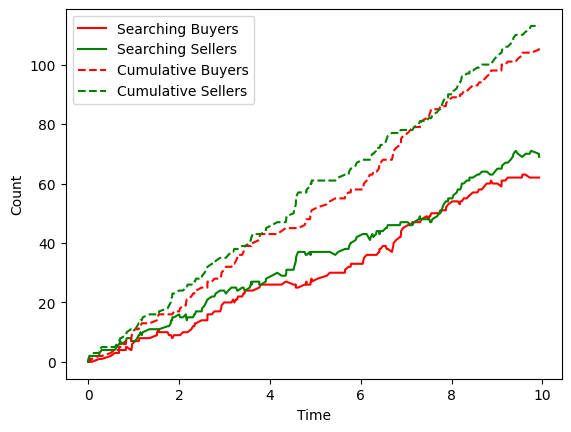

In [6]:
my_market = ArrivalMarket(
    expected_buyer_arrivals = 10,
    expected_seller_arrivals = 10,
    generate_buyer = lambda : np.random.normal(1,1),
    generate_seller = lambda : np.random.normal(2,0.5)
)
my_market.run_simulation(time_horizon=10, seed=610, xlabel="Time", ylabel="Count")

Seed: 458
Total loop time: 0.03365659713745117
Total clearing price time: 0.02667856216430664


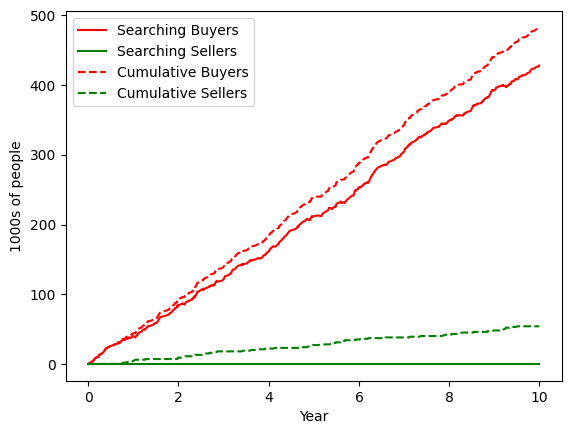

In [11]:
us_kidney_market = ArrivalMarket(
    expected_buyer_arrivals = 50000/1000, # new patients per year (1000s of people)
    expected_seller_arrivals = 6000/1000, # LKD arrivals per year (2023 rate, 1000s of people)
    generate_buyer = lambda : np.random.normal(1,1),
    generate_seller = lambda : np.random.normal(-0.1,0)
)
us_kidney_market.run_simulation(time_horizon=10, seed=458, xlabel="Year", ylabel="1000s of people") # 10 year simulation

Seed: 977
Total loop time: 0.10718941688537598
Total clearing price time: 0.0846550464630127


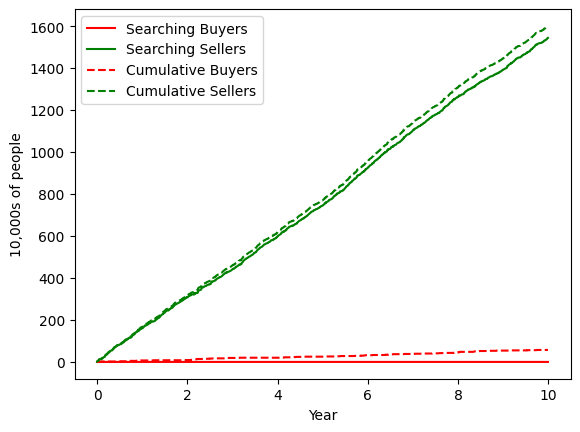

In [12]:
us_kidney_market = ArrivalMarket(
    expected_buyer_arrivals = 50000/10000, # new patients per year (10000s of people)
    expected_seller_arrivals = 1600000/10000, # New adults (18 and over) per year (2022 rate, 10000s of people)
    generate_buyer = lambda : np.random.normal(2,1),
    generate_seller = lambda : np.random.normal(1,1)
)
us_kidney_market.run_simulation(time_horizon=10, xlabel="Year", ylabel="10,000s of people") # 10 year simulation